In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torch import Tensor

import torchvision
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm

from IPython import display

%load_ext autoreload
%autoreload 2

In [2]:
class ImagesDataset(data.Dataset):
    def __init__(self, file):
        data = np.load(file)
        
        self.images = self.torch_image(data["images"]) if "images" in data else None
        self.labels = torch.from_numpy(data["labels"]).cuda() if "labels" in data else None

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        return {
            "images": self.images[idx].cuda(),
            "labels": self.labels[idx] if self.labels is not None else self.images[idx].cuda()
        }
        
    def torch_image(self, img):
        return torch.from_numpy(img.astype(np.float32)).permute(0,3,1,2)

In [3]:
class Trainer:
    def __init__(self, model, lr=0.001, criterion=nn.CrossEntropyLoss(), gamma=0.95, step_size=100):
        self.model = model
        self.optimizer = optim.Adam(model.parameters(), lr=lr)
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=step_size, gamma=gamma)
        self.criterion = criterion
        self.losses = []
        
    def fit(self, loader, epochs=5, print_each=100):
        self.losses = []
        
        self.model.train()
        
        for epoch in range(epochs):
            for i, batch in enumerate(loader):
                self.scheduler.step()

                images = Variable(batch["images"]).cuda()
                labels = Variable(batch["labels"]).cuda()

                y_pred = self.model(images)
                loss = self.criterion(y_pred, labels)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                self.losses.append(np.log(loss.data[0]))
                
                if i % 100 == 0 and i > 0:
                    plt.plot(self.losses)
                    display.clear_output(wait=True)
                    display.display(plt.show())

                    print("epoch: {}".format(epoch))
                    print("label_loss: {:0.4f} label_LR: {:0.4f}".format(loss.data[0], self.scheduler.get_lr()[0]))

        self.model.eval()

In [4]:
train_dataset = ImagesDataset("nsketch-train.npz")
dev_dataset = ImagesDataset("nsketch-dev.npz")
test_dataset = ImagesDataset("nsketch-test.npz")

In [5]:
BATCH_SIZE = 32
train_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
dev_loader = data.DataLoader(dev_dataset, batch_size=BATCH_SIZE)
test_loader = data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [15]:
resnet = torchvision.models.resnet18(pretrained=True)
resnet.fc = torch.nn.Linear(resnet.fc.in_features, 256)

model = nn.Sequential(
    nn.Conv2d(1, 3, 1, 1),
    resnet
)

model.cuda();

In [16]:
batch = train_loader.__iter__().next()

In [17]:
trainer = Trainer(model)

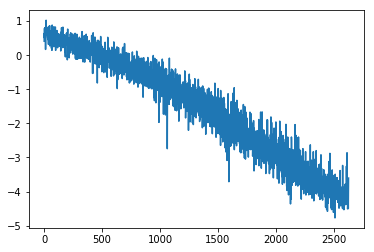

None

epoch: 4
label_loss: 0.0273 label_LR: 0.0002


In [21]:
trainer.fit(train_loader, epochs=5)

In [28]:
torch.save(model, "trained.pkl")

In [6]:
model = torch.load("trained.pkl")

In [17]:
ys = []

for batch in test_loader:
    pred = model(Variable(batch["images"])).cpu().data.numpy()
    ys.append(np.argmax(pred, axis=1))

ys = np.concatenate(ys)

In [16]:
np.mean(dev_dataset.labels.cpu().numpy() == ys)

0.73999999999999999

In [23]:
np.mean(preds == batch["labels"].cpu().numpy())

1.0

In [18]:
np.savetxt("transfer_learning.txt", ys, fmt="%d", delimiter="\n")